# Step 1: Utilize Additional Statistical and Econometric Models

## 1.1 Vector Autoregression (VAR)
Since we have only the oil price data, we will not use VAR. Instead, we'll focus on univariate models suitable for this data.

In [1]:
# load the dataset 
import pandas as pd
import matplotlib.pyplot as plt

# Load the Brent oil prices data
file_path = '../data/raw/BrentOilPrices.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

# Sort the data by date
data = data.sort_values(by='Date')

# Reset index after sorting
data.reset_index(drop=True, inplace=True)

## 1.2 Markov-Switching ARIMA
Markov-Switching ARIMA captures different market conditions by allowing the time series to switch between different regimes.

                        Markov Switching Model Results                        
Dep. Variable:                  Price   No. Observations:                 9011
Model:               MarkovRegression   Log Likelihood              -35281.967
Date:                Sun, 07 Jul 2024   AIC                          70575.934
Time:                        07:28:59   BIC                          70618.571
Sample:                             0   HQIC                         70590.441
                               - 9011                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0441      0.088    227.669      0.000      19.872      20.217
sigma2        26.3180      0.704     37.394      0.0

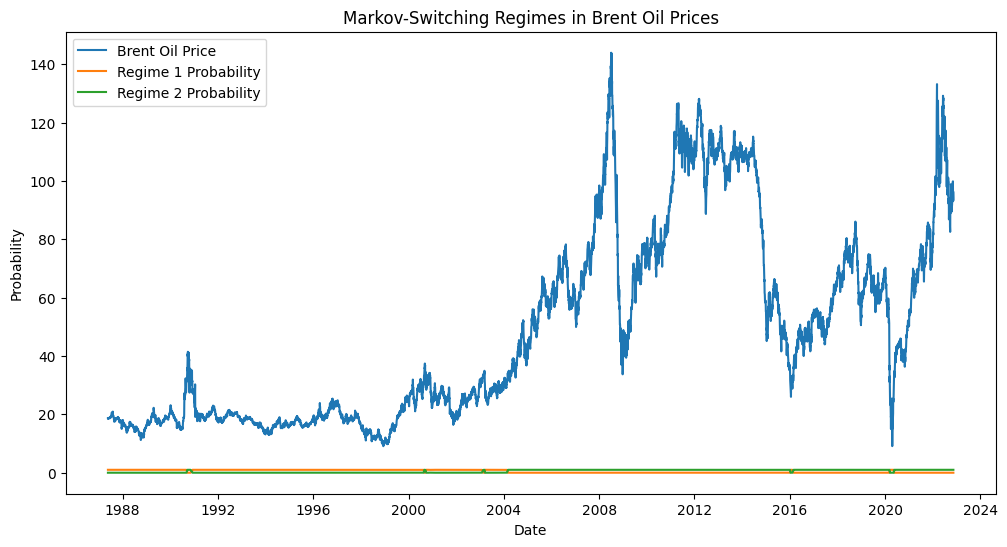

In [2]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit Markov-Switching ARIMA model
model = MarkovRegression(data['Price'], k_regimes=2, trend='c', switching_variance=True)
results = model.fit()

# Summary of the Markov-Switching ARIMA model
print(results.summary())

# Plot the regimes
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')
plt.plot(data['Date'], results.smoothed_marginal_probabilities[0], label='Regime 1 Probability')
plt.plot(data['Date'], results.smoothed_marginal_probabilities[1], label='Regime 2 Probability')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.title('Markov-Switching Regimes in Brent Oil Prices')
plt.legend()
plt.show()


## 1.3 Long Short-Term Memory (LSTM)
LSTM models capture complex patterns and dependencies in time series data.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Actual Price')
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict
plt.plot(data['Date'][:len(train_plot)], train_plot, label='Train Predict')

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict
plt.plot(data['Date'], test_plot, label='Test Predict')

plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Brent Oil Prices - LSTM Prediction')
plt.legend()
plt.show()
